In [102]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [103]:
import IPython


def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [104]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
data = pd.read_csv("data.csv")

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(data.shape)

(21434470, 47)
(853720, 46)
(21434469, 2)
(14181090, 23)


In [113]:
data[data['id'] == 'FOODS_3_090_CA_3_validation'].head()
data[(data['id'] == 'FOODS_3_090_CA_3_validation') & (data['demand'] > 0) & (data['part'] == 'train')]
df = data[(data['date'] <= '2016-04-24') & (data['id'] == 'FOODS_3_090_CA_3_validation') & (data['demand'] > 0) & (data['demand'] <= 15)]
df = df[['date','demand','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','snap_WI','sell_price']]
df = df.set_index('date')
df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-15,2,2,0,2,0,30,4,1,1.0
2015-02-16,3,2,0,2,0,22,1,0,1.0
2015-02-17,2,2,0,2,0,30,4,0,1.0
2015-02-18,5,2,0,2,0,11,2,0,1.0
2015-02-21,6,2,0,2,0,30,4,0,1.0


In [114]:
def exponential_smoothing2(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    # Try to use df instead of list
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [120]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            print("series: ", series)
            print("output: ", exponential_smoothing(series, alpha))
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

In [121]:
'''df = X_test.loc[X_test['item_id'] == 300]

df = df[['sell_price','dept_id','cat_id','store_id','state_id','shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_min_t7', 'rolling_min_t30' ,'rolling_min_t60', 'rolling_max_t7', 'rolling_max_t30' ,'rolling_max_t60', 'rolling_skew_t30', 'rolling_kurt_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'year', 'quarter', 'month' ,'week', 'day']]

df.head()'''

"df = X_test.loc[X_test['item_id'] == 300]\n\ndf = df[['sell_price','dept_id','cat_id','store_id','state_id','shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_min_t7', 'rolling_min_t30' ,'rolling_min_t60', 'rolling_max_t7', 'rolling_max_t30' ,'rolling_max_t60', 'rolling_skew_t30', 'rolling_kurt_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'year', 'quarter', 'month' ,'week', 'day']]\n\ndf.head()"

In [122]:
#df['sell_price']
#df.reset_index(inplace=True)

series:  date
2015-02-15    2
2015-02-16    3
2015-02-17    2
2015-02-18    5
2015-02-21    6
2015-02-24    1
2015-02-26    1
2015-02-27    2
2015-03-01    2
2015-03-02    2
2015-03-03    2
2015-03-04    2
2015-03-05    1
2015-05-17    1
2015-05-19    3
2015-05-21    4
2015-05-22    1
2015-05-24    3
2015-05-25    2
2015-05-26    2
2015-05-28    1
2015-05-30    1
2015-06-01    4
2015-06-03    3
2015-06-05    1
2015-06-06    2
2015-06-09    1
2015-06-11    3
2015-06-12    9
2015-12-05    2
2015-12-07    1
2015-12-10    9
2015-12-11    1
2015-12-12    3
2015-12-13    2
2015-12-14    1
2015-12-18    1
2015-12-20    6
2015-12-21    4
2015-12-22    5
2015-12-23    2
2015-12-26    6
2015-12-28    6
Name: demand, dtype: int64
output:  [2, 2.3, 2.21, 3.0469999999999997, 3.9328999999999996, 3.0530299999999992, 2.437120999999999, 2.3059846999999993, 2.2141892899999993, 2.1499325029999996, 2.1049527520999995, 2.0734669264699996, 1.7514268485289997, 1.5259987939702997, 1.9681991557792096, 2.577739

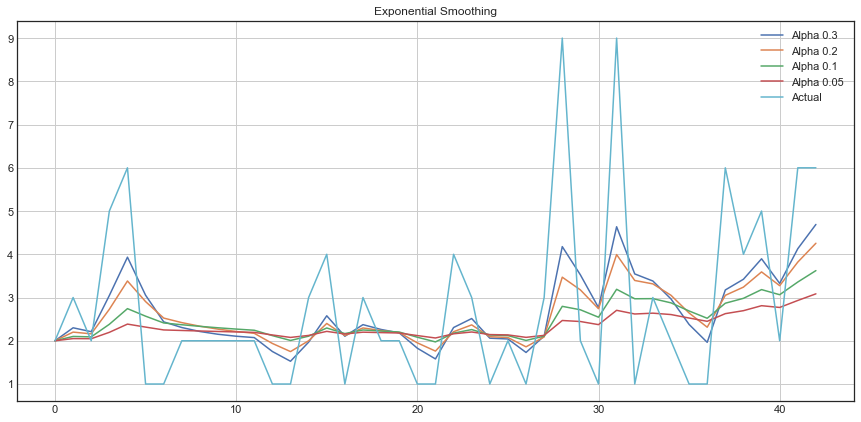

In [123]:
plotExponentialSmoothing(df['demand'], [0.3, 0.2, 0.1, 0.05])